In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

from collections import Counter
import re

In [2]:
df = pd.read_csv('../data/Sei/Sei_tracks_info.csv')

df = df[df['AUROC'] > 0.95]

df_pivot = df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)
df_pivot = df_pivot.map(lambda x: x if isinstance(x, list) else [])
df_pivot.shape

(1287, 1023)

In [3]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549', 'SK-N-SH_RA_Neuron_Brain']

In [4]:
df_track = pd.DataFrame(index=cell_types, columns=assays)

for i, cell_type in enumerate(cell_types):
    cell_standard_name = cell_standard_names[i]
    df_track.loc[cell_type] = df_pivot.loc[cell_standard_name]

df_track.loc['SK-N-SH'] = df_pivot.loc['SK-N-SH_Neuroblastoma_cell_Brain'] + df_pivot.loc['SK-N-SH_RA_Neuron_Brain']

df_track.map(len)

,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,57,87,23,5,7,3,15,29
HepG2,9,8,8,2,1,2,0,17
SK-N-SH,4,4,3,1,0,1,0,7
HCT116,6,45,47,1,23,2,0,14
A549,4,45,53,0,36,0,1,10


In [5]:
pred_array = load_h5('outputs/cCRE_Sei_pred.h5')
print(pred_array.shape)

(368038, 21907)


In [6]:
MPRA_df = pd.read_csv('../data/cCRE/cCRE_5_cell_types.csv')
print(MPRA_df.shape)

(368038, 12)


In [8]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_track.loc[cell_type, assay]
        if len(indice) > 0:
            pred = logit(pred_array[:, indice], eps=1e-6).mean(1)
            MPRA_df[f'{cell_type}_{assay}'] = pred
        else:
            MPRA_df[f'{cell_type}_{assay}'] = np.nan

MPRA_df

,chr,start,end,name_1,name_2,cCRE_type,K562_cCRE_type,HepG2_cCRE_type,SK-N-SH_cCRE_type,HCT116_cCRE_type,A549_cCRE_type,seq,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,chr1,115562,115912,EH38F0000002,EH38E3951280,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CAGATTATACTACAGTGAAAGTTGCCAATGACAAGGCAAAGTCACT...,-3.024,-5.532,-4.683,-7.525,-4.649,-9.281,-6.941,-5.365,-6.590,-6.352,-7.275,-6.185,-6.030,-9.424,NaN,-5.468,-5.162,-5.328,-6.237,-4.885,NaN,-8.060,NaN,-5.615,-4.484,-6.798,-6.767,-7.010,-6.113,-9.908,NaN,-5.643,-3.580,-6.179,-6.039,NaN,-6.337,NaN,-8.742,-5.022
1,chr1,138917,139112,EH38D6144710,EH38E3951286,pELS,pELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,GAGGCAGGAGCTGGGCCTGGACAGGTCAACTTGAGGAGATTTTGGG...,-1.475,-8.215,-7.756,-9.381,-6.974,-9.250,-3.797,-0.013,-2.360,-7.084,-8.018,-7.517,-7.927,-8.792,NaN,1.667,-3.494,-7.669,-8.042,-5.879,NaN,-7.069,NaN,1.208,0.864,-6.693,-6.865,-5.967,-5.621,-8.887,NaN,1.438,0.088,-7.712,-7.545,NaN,-8.101,NaN,-7.935,1.743
2,chr1,181014,181237,EH38D4327524,EH38E2776523,CA-H3K4me3,Low-DNase,Low-DNase,Low-DNase,CA-only,Low-DNase,GGCCCGCCCGCCCGGGTCTGACCTGAGGAGAACTGTGCTCCGCCTT...,0.763,-3.614,-4.439,-8.199,-5.549,-8.458,-2.557,-3.768,-1.049,-3.032,-6.052,-5.902,-6.790,-7.852,NaN,-3.748,0.392,-2.329,-5.065,-4.679,NaN,-8.975,NaN,-2.806,0.109,-3.224,-5.028,-6.097,-4.553,-8.184,NaN,-4.348,0.968,-2.229,-4.162,NaN,-6.692,NaN,-7.331,-3.460
3,chr1,181289,181639,EH38D4327525,EH38E2776524,CA-H3K4me3,CA-CTCF,CA-TF,CA-TF,CA-only,CA-only,CGCGCCGGCGCAGGCGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGC...,-0.181,-5.566,-5.613,-9.789,-7.090,-8.443,-2.141,-5.836,-1.809,-5.545,-7.007,-7.867,-8.005,-7.833,NaN,-5.892,-0.127,-5.015,-7.165,-6.751,NaN,-9.351,NaN,-4.646,0.326,-5.169,-5.690,-7.454,-4.975,-7.603,NaN,-5.655,0.551,-3.858,-5.179,NaN,-7.523,NaN,-6.790,-5.397
4,chr1,191294,191644,EH38D4327540,EH38E2776526,dELS,Low-DNase,Low-DNase,CA-only,Low-DNase,Low-DNase,ATCAGCAGGGACCGTGCACTCTCTTGGAGCCACCACAGAAAGCAGA...,-4.652,-7.207,-7.957,-7.108,-6.240,-9.451,-1.960,-7.251,-3.651,-5.183,-7.340,-3.837,-5.608,-8.419,NaN,-6.074,-0.492,-5.330,-7.089,-2.384,NaN,-8.298,NaN,-4.967,-4.315,-6.875,-8.131,-6.277,-6.067,-7.705,NaN,-7.506,-4.493,-6.971,-8.058,NaN,-7.691,NaN,-7.844,-6.641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368033,chrY,20828581,20828904,EH38D6144374,EH38E3951144,dELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CA-TF,TGGAAGAATTTAAAACAGAAATACCAGGCTGGGCGCGGTGGCTCAG...,-5.043,-7.078,-6.866,-9.356,-7.428,-10.184,-2.893,-8.863,-4.395,-4.911,-5.362,-8.312,-8.196,-9.798,NaN,-7.689,-8.416,-6.095,-5.183,-6.443,NaN,-9.418,NaN,-9.214,-2.788,-4.508,-4.287,-7.784,-2.484,-9.727,NaN,-7.465,-2.851,-4.012,-4.183,NaN,-6.083,NaN,-8.620,-7.634
368034,chrY,21021830,21022179,EH38D6144412,EH38E3951161,dELS,Low-DNase,dELS,Low-DNase,Low-DNase,Low-DNase,GCCAGTGGAAATCTTGTTGGGTTTCTCTCGTCCCACTAATGTTACC...,-3.373,-6.907,-6.172,-7.929,-4.013,-7.558,-5.812,-7.825,1.272,-2.963,-2.307,-5.730,-1.801,-8.386,NaN,-4.895,-3.495,-4.317,-1.698,-3.830,NaN,-7.070,NaN,-6.150,1.929,-4.580,-2.679,-7.488,-0.983,-8.615,NaN,-5.566,3.455,-2.881,-3.316,NaN,-3.912,NaN,-6.719,-4.588
368035,chrY,26315142,26315389,EH38D4327358,EH38E2776433,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,CA-TF,AATCTGCATTCCCTATACTAAAACACTTAAATGGAATGGGATAGAA...,-1.168,-8.098,-8.432,-8.144,-7.500,-9.565,-6.953,0.222,-2.974,-7.160,-

In [10]:
cols = [f'{cell_type}_{assay}' for cell_type in cell_types for assay in assays]
print(MPRA_df[cols].mean(), MPRA_df[cols].std())

K562_DNase         -3.947
K562_H3K4me3       -7.262
K562_H3K27ac       -7.176
K562_H3K27me3      -8.248
K562_H3K4me1       -6.324
K562_H3K36me3      -9.761
K562_H3K9me3       -4.998
K562_CTCF          -6.325
HepG2_DNase        -4.629
HepG2_H3K4me3      -6.426
HepG2_H3K27ac      -7.620
HepG2_H3K27me3     -5.949
HepG2_H3K4me1      -6.520
HepG2_H3K36me3     -9.208
HepG2_H3K9me3         NaN
HepG2_CTCF         -5.799
SK-N-SH_DNase      -4.154
SK-N-SH_H3K4me3    -6.354
SK-N-SH_H3K27ac    -7.069
SK-N-SH_H3K27me3   -4.867
SK-N-SH_H3K4me1       NaN
SK-N-SH_H3K36me3   -8.728
SK-N-SH_H3K9me3       NaN
SK-N-SH_CTCF       -5.822
HCT116_DNase       -3.029
HCT116_H3K4me3     -6.353
HCT116_H3K27ac     -6.636
HCT116_H3K27me3    -6.203
HCT116_H3K4me1     -5.199
HCT116_H3K36me3    -9.286
HCT116_H3K9me3        NaN
HCT116_CTCF        -5.729
A549_DNase         -2.767
A549_H3K4me3       -5.993
A549_H3K27ac       -6.853
A549_H3K27me3         NaN
A549_H3K4me1       -6.754
A549_H3K36me3         NaN
A549_H3K9me3

In [13]:
cols = [f'{cell_type}_{assay}' for cell_type in cell_types for assay in assays]
x = MPRA_df[cols].copy()
mean = x.mean()
std = x.std()
x = (x - mean) / std
MPRA_df[cols] = x
MPRA_df

,chr,start,end,name_1,name_2,cCRE_type,K562_cCRE_type,HepG2_cCRE_type,SK-N-SH_cCRE_type,HCT116_cCRE_type,A549_cCRE_type,seq,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,chr1,115562,115912,EH38F0000002,EH38E3951280,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CAGATTATACTACAGTGAAAGTTGCCAATGACAAGGCAAAGTCACT...,0.388,0.867,1.293,0.687,1.022,0.379,-0.929,0.294,-0.775,0.033,0.181,-0.151,0.272,-0.191,NaN,0.093,-0.417,0.459,0.401,-0.012,NaN,0.508,NaN,0.056,-0.487,-0.217,-0.071,-0.609,-0.457,-0.412,NaN,0.025,-0.305,-0.071,0.353,NaN,0.231,NaN,-0.315,0.093
1,chr1,138917,139112,EH38D6144710,EH38E3951286,pELS,pELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,GAGGCAGGAGCTGGGCCTGGACAGGTCAACTTGAGGAGATTTTGGG...,1.039,-0.478,-0.301,-1.076,-0.396,0.404,0.574,1.934,0.897,-0.291,-0.208,-1.005,-0.782,0.369,NaN,2.093,0.273,-0.589,-0.469,-0.656,NaN,1.263,NaN,1.899,1.303,-0.166,-0.123,0.178,-0.211,0.264,NaN,2.100,1.071,-0.655,-0.300,NaN,-0.744,NaN,0.332,2.034
2,chr1,181014,181237,EH38D4327524,EH38E2776523,CA-H3K4me3,Low-DNase,Low-DNase,Low-DNase,CA-only,Low-DNase,GGCCCGCCCGCCCGGGTCTGACCTGAGGAGAACTGTGCTCCGCCTT...,1.979,1.828,1.420,0.047,0.473,1.030,1.167,0.783,1.415,1.499,0.821,0.031,-0.150,1.200,NaN,0.575,1.878,1.802,0.966,0.122,NaN,-0.188,NaN,0.814,1.050,1.528,0.864,0.080,0.323,0.730,NaN,0.405,1.401,1.435,1.168,NaN,0.034,NaN,0.816,0.541
3,chr1,181289,181639,EH38D4327525,EH38E2776524,CA-H3K4me3,CA-CTCF,CA-TF,CA-TF,CA-only,CA-only,CGCGCCGGCGCAGGCGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGC...,1.582,0.850,0.811,-1.464,-0.467,1.042,1.365,0.150,1.114,0.389,0.321,-1.230,-0.825,1.218,NaN,-0.026,1.664,0.599,-0.046,-1.221,NaN,-0.475,NaN,0.318,1.123,0.578,0.508,-0.944,0.112,1.115,NaN,0.022,1.244,0.814,0.727,NaN,-0.425,NaN,1.250,-0.015
4,chr1,191294,191644,EH38D4327540,EH38E2776526,dELS,Low-DNase,Low-DNase,CA-only,Low-DNase,Low-DNase,ATCAGCAGGGACCGTGCACTCTCTTGGAGCCACCACAGAAAGCAGA...,-0.296,0.027,-0.405,1.083,0.051,0.245,1.452,-0.284,0.386,0.549,0.146,1.355,0.507,0.699,NaN,-0.077,1.513,0.458,-0.009,1.609,NaN,0.327,NaN,0.231,-0.431,-0.255,-0.804,-0.056,-0.434,1.048,NaN,-0.521,-0.647,-0.373,-0.523,NaN,-0.518,NaN,0.405,-0.372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368033,chrY,20828581,20828904,EH38D6144374,EH38E3951144,dELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CA-TF,TGGAAGAATTTAAAACAGAAATACCAGGCTGGGCGCGGTGGCTCAG...,-0.460,0.092,0.161,-1.052,-0.673,-0.335,1.006,-0.778,0.093,0.669,1.182,-1.516,-0.932,-0.522,NaN,-0.530,-1.761,0.116,0.909,-1.021,NaN,-0.525,NaN,-0.916,0.081,0.901,1.263,-1.193,1.357,-0.292,NaN,-0.509,-0.031,0.755,1.159,NaN,0.371,NaN,-0.217,-0.657
368034,chrY,21021830,21022179,EH38D6144412,EH38E3951161,dELS,Low-DNase,dELS,Low-DNase,Low-DNase,Low-DNase,GCCAGTGGAAATCTTGTTGGGTTTCTCTCGTCCCACTAATGTTACC...,0.241,0.178,0.521,0.303,1.410,1.742,-0.389,-0.460,2.332,1.529,2.781,0.141,2.623,0.728,NaN,0.253,0.272,0.912,2.590,0.672,NaN,1.263,NaN,-0.089,1.660,0.866,2.127,-0.969,2.107,0.444,NaN,0.048,2.333,1.187,1.535,NaN,1.571,NaN,1.307,0.217
368035,chrY,26315142,26315389,EH38D4327358,EH38E2776433,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,CA-TF,AATCTGCATTCCCTATACTAAAACACTTAAATGGAATGGGATAGAA...,1.167,-0.419,-0.651,0.098,-0.717,0.155,-0.935,2.006,0.654,-0.324,-0.908,-1.319,-0.765,-0.448,NaN,2.187,0.958,0.277,-0.032,-1.133,NaN,0.132,NaN,2.293,1.443,-0.137,-0.389,0.797,-0.374,-1.095,NaN,2.135,1.599,0.150

In [14]:
MPRA_df.to_csv('../data/cCRE/cCRE_5_cell_types_Sei_feature_0617_norm.csv', index=False)

In [15]:
print(MPRA_df['seq'].str.len().min(), MPRA_df['seq'].str.len().max())

150 350


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'PLS'),
  Text(1, 0, 'pELS'),
  Text(2, 0, 'dELS'),
  Text(3, 0, 'CA-H3K4me3'),
  Text(4, 0, 'CA-CTCF'),
  Text(5, 0, 'CA-TF'),
  Text(6, 0, 'CA-only'),
  Text(7, 0, 'Low-DNase')])

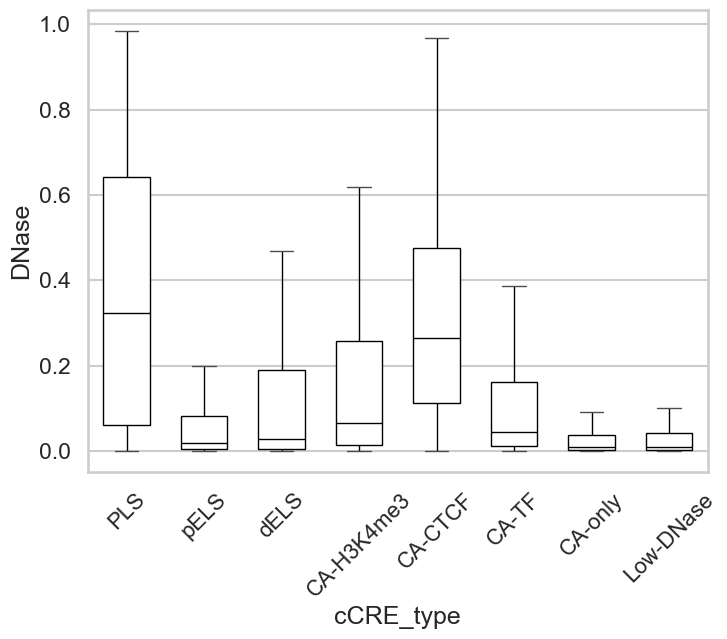

In [49]:
cCRE_types = ['PLS', 'pELS', 'dELS', 'CA-H3K4me3', 'CA-CTCF', 'CA-TF', 'CA-only', 'Low-DNase']

plot_data = []
for cell_type in cell_types[:1]:
    for cCRE_type in cCRE_types:
        df = MPRA_df[MPRA_df[f'{cell_type}_cCRE_type'] == cCRE_type]
        values = df[f'{cell_type}_DNase'].dropna()
        # plot_data.append(values)
        for v in values:
            plot_data.append({
                "cCRE_type": cCRE_type,
                "DNase": v
            })
            
plot_df = pd.DataFrame(plot_data)
sns.boxplot(data=plot_df, x="cCRE_type", y="DNase", fliersize=0, width=0.6,
            boxprops={"facecolor":"white", "edgecolor":"black"},
            whiskerprops={"color":"black"},
            medianprops={"color":"black"})
# sns.stripplot(data=plot_df, x="cCRE_type", y="DNase", color='black', jitter=True, size=3)

# plt.boxplot(x=plot_data, positions=range(len(cCRE_types)))
# plt.xticks(ticks=range(len(cCRE_types)), labels=cCRE_types, rotation=45)
# plt.ylabel('DNase')
plt.xticks(fontsize=16, rotation=45)